# Creación de espectrogramas y visualización

In [2]:
import os
import pandas as pd
import sys

sys.path.insert(1, '/home/martin/Documentos/PI-Thalamus/01 Thalamus-PI/iESPnet_SRC_main/utilities')
import IO # customized functions for navigating throught the folders and files

import numpy as np
import mne
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import librosa
import torch
import torchaudio.transforms as T
import scipy.fft as sp_fft
import re

In [3]:
DATA_DIR = "/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data"
RNSIDS = IO.get_subfolders(DATA_DIR)

In [4]:
print(len(RNSIDS),'\n')
print(RNSIDS)

32 

['PIT-RNS1603', 'PIT-RNS6989', 'PIT-RNS3016', 'PIT-RNS1529', 'PIT-RNS7168', 'PIT-RNS4098', 'PIT-RNS1836', 'PIT-RNS9183', 'PIT-RNS1440', 'PIT-RNS1713', 'PIT-RNS9536', 'PIT-RNS2543', 'PIT-RNS1438', 'PIT-RNS1534', 'PIT-RNS9793', 'PIT-RNS1703', 'PIT-RNS1556', 'PIT-RNS1597', 'PIT-RNS6992', 'PIT-RNS8326', 'PIT-RNS2227', 'PIT-RNS8163', 'PIT-RNS4998', 'PIT-RNS8973', 'PIT-RNS6806', 'PIT-RNS1090', 'PIT-RNS2368', 'PIT-RNS6762', 'PIT-RNS2938', 'PIT-RNS7525', 'PIT-RNS0427', 'PIT-RNS8076']


## Funciones con las que se van a cargar los datos de iEEG

In [5]:
# funciones para cargar los datos 

def get_data_files(address, subfolder, endswith='.edf', Verbose=True):
    """
    Get file from a given subject.

    given an address to a subject folder and a list of subfolders,
    provides a list of all files matching the endswith.

    To access to a particular vhdr_file please see 'read_BIDS_file'.

    Parameters
    ----------
    subject_path : string
    subfolder : list
    endswith ; string
    Verbose : boolean, optional

    Returns
    -------
    iles : list
        list of addrress to access to a particular vhdr_file.
    """
    files = []
    session_path = address + '/' + subfolder 
    # only data whose annotation exist will be loaded
    annot_files = get_annot_files(address, subfolder, Verbose=False)
    if endswith == '.edf':
        prestr = len(endswith)+1  # for checking pre-file extention string
        for f_name in os.listdir(session_path):
            if f_name.lower().endswith(endswith) and f_name[-prestr].isnumeric():
                aux = f_name[:-len(endswith)]  # check annot
                if any(aux in s for s in annot_files):
                    files.append(session_path + '/' + f_name)
                    if Verbose:
                        print(f_name)
    else:
        for f_name in os.listdir(session_path):
            if f_name.endswith(endswith):
                aux = f_name[:-(len(endswith)+5)]  # check annot
                if any(aux in s for s in annot_files):
                    files.append(session_path + '/' + f_name)
                    if Verbose:
                        print(f_name)
    files.sort()
    return files

def get_annot_files(address, subfolder, Verbose=True):
    """
    Get annot file from a given subject.

    given an address to a subject folder and a list of subfolders,
    provides a list of all files matching the endswith.

    To access to a particular vhdr_file please see 'read_BIDS_file'.
    To get info from vhdr_file please see 'get_sess_run_subject'

    Parameters
    ----------
    subject_path : string
    subfolder : list
    Verbose : boolean, optional

    Returns
    -------
    iles : list
        list of addrress to access to a particular vhdr_file.
    """
    files = []
    session_path = address + '/' + subfolder 
    annot1_eof = 'sz-vk.txt'
    anno2_eof = 'sz-nz.txt'  # this files contain both VK and NZ annots
    txt_files_1 = [f for f in os.listdir(session_path) if f.lower().endswith(annot1_eof)]
    txt_files_2 = [f for f in os.listdir(session_path) if f.lower().endswith(anno2_eof)]

    # anno2_eof files are annotation files of first order priority
    aux_prefix = np.repeat(session_path + '/', len(txt_files_2))
    files = [x + y for x, y in zip(aux_prefix, txt_files_2)]
    # now check if annot1 exists but not annot2
    for f, f_name in enumerate(txt_files_1):
        aux = f_name[:-len(annot1_eof)]  # aux name file which annot
        if any(aux in s for s in txt_files_1) and not any(aux in s for s in txt_files_2):
            files.append(session_path + '/' + f_name)
        if Verbose:
            print(f_name)
    # check files are not empty files
    files = [ f for f in files if  os.stat(f).st_size != 0]
    files.sort()
    return files

def get_epochs_zeropad_all(data_file, events, twindow=90.0):
    """
    Extract epochs from file at a given twindow length.

    This function segments data in fixed epochs. If a file is shorter than 
    90 s, then zeropadding. If it is longer, then non-overlapping 90 s segments
    are extracted. 
    
    Useful for creating spectrogram of edf files with annotations (aka PITT)


    Parameters
    ----------
    data : array, shape(n_channels, n_samples)
        either cortex of subcortex data to be epoched.
    events : array, shape(n_events,2)
        All events that were found by the function
        'get_events'.
        The first column contains the event time seconds and the second column
        contains the event id.
    twindow : float
        length of the epoch.

    Returns
    -------
    X : array, shape(n_events, n_channels, n_samples)
        epoched data
    Y : array, shape(n_events, n_samples)
        label information, no_sz=0, sz_on=1, sz=2.
        See 'get_events' for more information regarding labels names.
    Z : array, shape(n_events, n_samples)
        time of the sz_on.
    """
    raw = mne.io.read_raw_edf(data_file)
    sf = raw.info['sfreq']
    data = raw.get_data()
    n_channels, time_rec = np.shape(data)
    # labels
    idx_eof = np.where(events[:, 1] == 0)[0]
    eof_event_time = events[idx_eof, 0]  # in seconds
    # add zero for first eof
    eof_event_time = np.hstack((0.0, eof_event_time))
    # # check recording lenght is at least 90s
    rec_len = [t - s for s, t in zip(eof_event_time, eof_event_time[1:])]
    # files shorter than 60 are discarded.
    idx_shorttrials = np.where(np.asarray(rec_len) < 60)[0]

    # delete short trials:
    idx_eof_new = np.delete(idx_eof, idx_shorttrials)
    eof_event_time_new = events[idx_eof_new, 0]
    rec_len_new = np.delete(rec_len, idx_shorttrials)

    # check if annot time is not longer than file time
    idx_stop = np.where(np.dot(eof_event_time_new, sf) > time_rec)

    # avoid trying to read those trials
    idx_eof_ = np.delete(idx_eof_new, idx_stop)
    nTrials = len(idx_eof_)

    Y = np.zeros((nTrials,)).astype(int)  # labels
    Z = np.zeros((nTrials,))  # time
    n_samples = int(round((twindow)*sf))
    X = np.zeros((nTrials, n_channels, n_samples))
    
    # extract epochs starts
    for i in range(nTrials):
        len_archive = rec_len_new[i]
        time_sof = eof_event_time_new[i] - len_archive
        start_epoch = int(round(time_sof * sf))
        if len_archive >= twindow:
            stop_epoch = int(round((time_sof + twindow) * sf))
            final_epoch = stop_epoch
            epoch = data[:, start_epoch:stop_epoch]
        else:
            stop_epoch = int(round((time_sof + len_archive) * sf))
            final_epoch = int(round((time_sof + twindow) * sf))
            epoch = data[:, start_epoch:stop_epoch]
            # pad the time that is not part of the shortened epoch to reach twindow
            time_to_pad = final_epoch - stop_epoch # in samples
        
            
            if time_to_pad > 0:
             
                # using zeros
                pad_data = np.zeros((4, time_to_pad))
                epoch = np.concatenate((epoch,pad_data),1)
                # now extract only the data fit to the frame
                epoch = epoch[:, :n_samples]
            # using 0.5s to pad.
            pad_length = int(round(0.1 * sf))
            pad_data = data[:,(stop_epoch - pad_length):stop_epoch]
            num_pad_reps = int(np.floor(time_to_pad/pad_length) + 1)
            total_pad_data = np.tile(pad_data,num_pad_reps)
            epoch = np.concatenate((epoch,total_pad_data),1)
            # now extract only the data fit to the frame
            epoch = epoch[:, :n_samples]
        # check lenght epoch
        if (final_epoch - start_epoch) != n_samples:
            raise ValueError('epoch lengths does not represent time window')
        
        X[i] = epoch

        if idx_eof_[i] != len(events)-1:
            if events[idx_eof_[i] - 1, 1] != 0 and (idx_eof_[i] - 1) != -1:  # then is sz_on
                # label
                Y[i] = events[idx_eof_[i] - 1, 1]
                # time
                time_sz = events[idx_eof_[i] - 1, 0]
                time = time_sz - time_sof
                time_eof = events[idx_eof_[i], 0]
                if len_archive > twindow:  # large archive
                    if time > twindow:  # sz happens and epoch didn't capture it
                        n_90 = int(len_archive / twindow)  # n of 90 s in axive
                        t_90 = time / twindow  # in which n time happens
                        if n_90 < t_90:  # sz is happening closer the end
                            # redefine epoch from eof to - 90
                            start_epoch = int(round((time_eof - twindow) * sf))
                            stop_epoch = int(round(time_eof * sf))
                            epoch = data[:, start_epoch:stop_epoch]
                            X[i] = epoch

                            # time
                            time = twindow - (time_eof - time_sz)
                        else:
                            # make sure we pick up the correct 90 s
                            start_epoch = int(round((time_sof + int(t_90)*twindow) * sf))
                            stop_epoch = int(round((time_sof + int(t_90)*twindow + twindow) * sf))
                            epoch = data[:, start_epoch:stop_epoch]
                            X[i] = epoch

                            # time
                            time = time_sz - time_sof - int(t_90)*twindow 
                if np.sign(time) == -1:
                    raise ValueError('Time cannot be negative')
                Z[i] = time
    return X, Y, Z

def get_events(annot_file, Verbose=False):
    """
    Clean annotation file and generate event array.

    Parameters
    ----------
    annot_files : str
        annot_file.

    Returns
    -------
    events : array
        time and event type information.

    """

    annot_ = np.loadtxt(annot_file, delimiter=',', skiprows=1, dtype=str)
    annot_ = annot_[:,[0,-1]]
    # we define here the valid labels
    idx = [idx for idx, s in enumerate(annot_[:, 1]) if "eof" not in s]
    idx2 = [idx for idx, s in enumerate(annot_[idx, 1]) if "sz_" not in s]

    idx_2delete = []
    for i in range(len(idx2)):
        idx_2delete.append(idx[idx2[i]])

    idx_2delete = np.asarray(idx_2delete).astype(int)
    if Verbose:
        print(str(len(idx_2delete))+' events deleted')

    events = np.delete(annot_, idx_2delete, 0)
    # change and arrange categorical to discrete labels
    # eof == 0, sz_on_*==1, sz*==2
    idx_eof = [idx for idx, s in enumerate(events[:, 1]) if "eof" in s]
    idx_sz_ = [idx for idx, s in enumerate(events[:, 1]) if "sz" in s]
    idx_sz_on = [idx for idx, s in enumerate(events[:, 1]) if "sz_on" in s]
    # the sz_ get everything with sz. the class "sz with onset" will be get
    # as a difference between the idx_sz and idx_sz_on
    idx_sz = set(idx_sz_) - set(idx_sz_on)
    idx_sz = list(idx_sz)

    events[idx_eof, 1] = 0
    events[idx_sz_on, 1] = 1
    events[idx_sz, 1] = 2

    events = events.astype(float)
    return events

## PIT-RNS2227

In [5]:
# buscar indice del paciente: PIT-RNS2227

indice= RNSIDS.index('PIT-RNS2227')
print(indice,'\n')
print(RNSIDS[indice])

20 

PIT-RNS2227


In [6]:
s = indice

data_files  = get_data_files(DATA_DIR, RNSIDS[indice], Verbose=False)
annot_files = get_annot_files(DATA_DIR, RNSIDS[indice], Verbose=False)

In [7]:
data_files

['/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS2227/PIT-RNS2227_PE20160705-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS2227/PIT-RNS2227_PE20160811-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS2227/PIT-RNS2227_PE20161012-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS2227/PIT-RNS2227_PE20161215-1.EDF']

In [8]:
annot_files

['/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS2227/PIT-RNS2227_PE20160705-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS2227/PIT-RNS2227_PE20160811-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS2227/PIT-RNS2227_PE20161012-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS2227/PIT-RNS2227_PE20161215-1_EOF_SZ-VK.TXT']

In [9]:
# se adquieren los datos de la epoca

events           = get_events(annot_files[0], Verbose=False)
X, labels, times = get_epochs_zeropad_all(data_files[0], events)

Extracting EDF parameters from /media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS2227/PIT-RNS2227_PE20160705-1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [10]:
X.shape

(99, 4, 22500)

Duda de por que para el paciente PIT-RNS2227 no hay datos en ninguna epoca. Viendo los datos que nos habian enviado antes, los txt no estaban guardados como VK

## Funcion para saber si todas las epocas de los distintos pacientes contienen datos 

In [ ]:
lista = set() # evita duplicados

for i in range(len(RNSIDS)):
    data_files  = get_data_files(DATA_DIR, RNSIDS[i], Verbose=False)
    annot_files = get_annot_files(DATA_DIR, RNSIDS[i], Verbose=False)

    for j in range(len(data_files)):
        events           = get_events(annot_files[j], Verbose=False)
        X, labels, times = get_epochs_zeropad_all(data_files[j], events)
        if X.shape[0] == 0:
            print('no hay datos en {} en la epoca {}'.format(RNSIDS[i], j))
            lista.add(RNSIDS[i])

lista=list(lista)

In [ ]:
print(lista)
print()
print(len(lista))

[]

0


### PIT-RNS8326 

Este paciente en la primer epoca no trae datos

In [ ]:
id = lista[2] 

data_files  = get_data_files(DATA_DIR, id, Verbose=False)
annot_files = get_annot_files(DATA_DIR, id, Verbose=False)

In [33]:
data_files

['/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS8326/PIT-RNS8326_PE20181212-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS8326/PIT-RNS8326_PE20181212-2.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS8326/PIT-RNS8326_PE20190226-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS8326/PIT-RNS8326_PE20190423-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS8326/PIT-RNS8326_PE20190723-1.EDF']

In [34]:
annot_files

['/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS8326/PIT-RNS8326_PE20181212-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS8326/PIT-RNS8326_PE20181212-2_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS8326/PIT-RNS8326_PE20190226-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS8326/PIT-RNS8326_PE20190423-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS8326/PIT-RNS8326_PE20190723-1_EOF_SZ-VK.TXT']

In [ ]:
lista_2 = []
lista_3 = []

for i in range(len(data_files)):
    events           = get_events(annot_files[i], Verbose=False)
    X, labels, times = get_epochs_zeropad_all(data_files[i], events)
    lista_2.append(X.shape[0])
    lista_3.append(labels)

print()
print(lista_2)
print(lista_3)

## Visualización y cantidad de espectrogramas

In [6]:
print(RNSIDS)
indice = 1

['PIT-RNS1603', 'PIT-RNS6989', 'PIT-RNS3016', 'PIT-RNS1529', 'PIT-RNS7168', 'PIT-RNS4098', 'PIT-RNS1836', 'PIT-RNS9183', 'PIT-RNS1440', 'PIT-RNS1713', 'PIT-RNS9536', 'PIT-RNS2543', 'PIT-RNS1438', 'PIT-RNS1534', 'PIT-RNS9793', 'PIT-RNS1703', 'PIT-RNS1556', 'PIT-RNS1597', 'PIT-RNS6992', 'PIT-RNS8326', 'PIT-RNS2227', 'PIT-RNS8163', 'PIT-RNS4998', 'PIT-RNS8973', 'PIT-RNS6806', 'PIT-RNS1090', 'PIT-RNS2368', 'PIT-RNS6762', 'PIT-RNS2938', 'PIT-RNS7525', 'PIT-RNS0427', 'PIT-RNS8076']


In [7]:
data_files  = get_data_files(DATA_DIR, RNSIDS[indice], Verbose=False)
annot_files = get_annot_files(DATA_DIR, RNSIDS[indice], Verbose=False)

In [8]:
data_files

['/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190319-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190423-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190507-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190625-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190708-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190709-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190903-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190903-2.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20191015-1.EDF',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989

In [9]:
annot_files 

['/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190319-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190423-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190507-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190625-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190708-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190709-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190903-1_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190903-2_EOF_SZ-VK.TXT',
 '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20191015-1_EOF_SZ-V

In [10]:
events           = get_events(annot_files[0], Verbose=False)
X, labels, times = get_epochs_zeropad_all(data_files[0], events)
X.shape


Extracting EDF parameters from /media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190319-1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


(88, 4, 22500)

In [11]:
e=26

epoch = X[e, :, :]
signal = torch.from_numpy(epoch)
signal = (signal - signal.mean()) / signal.std()

In [12]:
raw = mne.io.read_raw_edf(data_files[3])
sf = raw.info['sfreq'] # frecuencia de muestreo
intervalo_tiempo = 1 / sf # segundos entre cada muestra
t_1 = np.arange(signal.shape[1])
tiempo  = t_1 * intervalo_tiempo
ticks_x = np.arange(0, tiempo.max()+1, 10)

Extracting EDF parameters from /media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190625-1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [13]:
def get_spectrogram(signal, fs, n_fft = 256, win_len = None, hop_len = None,
                    power = 2.0):
    wind_dic={
              'periodic':True,
              'beta':10}
    spectrogram = T.Spectrogram(n_fft=n_fft, win_length=win_len,
                                hop_length=hop_len, pad=0,
                                window_fn =torch.kaiser_window,
                                normalized=False,
                                power=power, wkwargs=wind_dic)
    time = np.arange(win_len/2, signal.shape[-1] + win_len/2 + 1,
                     win_len - (win_len-hop_len))/float(fs)
    time -= (win_len/2) / float(fs)
    freqs = sp_fft.rfftfreq(n_fft, 1/fs)
    return spectrogram(signal), time, freqs

ECOG_SAMPLE_RATE = 250
ECOG_CHANNELS = 4

TT = 1000 # window length
overlap = 500 #
SPEC_WIN_LEN = int(ECOG_SAMPLE_RATE * TT / 1000 ) # win size
SPEC_HOP_LEN = int(ECOG_SAMPLE_RATE * (TT - overlap) / 1000)   # Length of hop between windows.

SPEC_NFFT = 500  # to see changes in 0.5 reso
top_db = 40.0

spec, t, f = get_spectrogram(signal, ECOG_SAMPLE_RATE, SPEC_NFFT, SPEC_WIN_LEN, SPEC_HOP_LEN)

# spec to DB
spec = librosa.power_to_db(spec, top_db=top_db)

# save up to 60 Hz
idx_60 = np.where(f<= 60)[0][-1]
spec = spec[:, :idx_60,:]

In [14]:
# smoothing label

# para visualizar el label primero realizaremos la transformacion con smoothing label: clase para transformar el label a continuo
class smoothing_label(object):
    def __call__(self, label, n=5, std=2.5):
        """"apply label smoothing."""
        label_time_smooth = label.copy()
        # for idx in range(len(label)):
        leng = len(label)
        idx_t = np.where(label==1)[0]
        
        if len(idx_t)!=0:
            if leng  - idx_t < n:
                n = leng  - idx_t
                aux = np.arange(idx_t-n,idx_t+n,1)
            elif idx_t - n < 0 : # in the very begining
                n = n + (idx_t - n)
                aux = np.arange(idx_t-n,idx_t+n,1)
            else:
                aux = np.arange(idx_t-n,idx_t+n,1)
                
            if aux.size!=0:                
                gaus =np.exp(-np.power(aux - idx_t, 2.) / (2 * np.power(std, 2.)))
                label_time_smooth[aux] = gaus
            else:
                label_time_smooth[idx_t] = 1
        return label_time_smooth

In [15]:
 # label time
label_time = np.zeros((spec.shape[2],))

if labels[e] !=0:
    idx_t = np.where(t<=times[e])[0][-1]
    label_time[idx_t]=1

In [16]:
target_transform_1 = smoothing_label()
label_1=target_transform_1(label_time)

In [22]:
pattern = re.compile(r'PE\d{8}-\d')

extracted_parts = [pattern.search(path).group(0) for path in data_files]

print(extracted_parts)

['PE20190319-1', 'PE20190423-1', 'PE20190507-1', 'PE20190625-1', 'PE20190708-1', 'PE20190709-1', 'PE20190903-1', 'PE20190903-2', 'PE20191015-1', 'PE20191104-1', 'PE20200225-1', 'PE20200721-1']


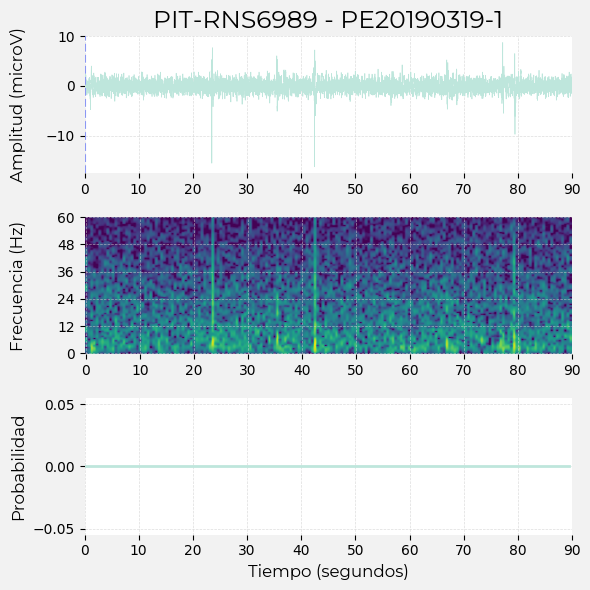

In [23]:
font_path= 'Montserrat-Regular.ttf'
montserrat = fm.FontProperties(fname=font_path)

fig, axs = plt.subplots(3, 1, figsize=(6, 6), facecolor='#F2F2F2')

plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1, hspace=0.4)

# iEEG
axs[0].plot(tiempo, signal[0, :], color='#BEE6DC', linestyle='-', linewidth=0.5)
axs[0].set_xticks(ticks_x)
axs[0].set_title('{} - {}'.format(RNSIDS[indice],extracted_parts[0]), fontproperties=montserrat, fontsize=18)
#axs[0].set_xlabel('Tiempo (segundos)', fontsize=12, fontproperties=montserrat)
axs[0].set_ylabel('Amplitud (microV)', fontsize=12, fontproperties=montserrat,labelpad=25)
axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#CFCFCF')
axs[0].set_xlim(0, 90)

axs[0].axvline(x=times[e], color='#8B97F4', linestyle='--', linewidth=1.5)

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)

# Espectrograma
axs[1].imshow(spec[0, :, :], origin='lower', aspect='auto')
#axs[1].set_title('Espectrograma {}'.format(RNSIDS[indice]), fontproperties=montserrat, fontsize=16)
#axs[1].set_xlabel('Tiempo (segundos)', fontsize=12, fontproperties=montserrat)
axs[1].set_ylabel('Frecuencia (Hz)', fontsize=12, fontproperties=montserrat,labelpad=25)
axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#CFCFCF')

# Etiquetas del eje X para que correspondan a 0-90 segundos
num_xticks = 10
x_tick_positions = np.linspace(0, spec.shape[2], num_xticks)
x_tick_labels = [str(int(x * 90 / (spec.shape[2] - 1))) for x in x_tick_positions]
axs[1].set_xticks(x_tick_positions)
axs[1].set_xticklabels(x_tick_labels)

# Etiquetas del eje Y para que correspondan a las frecuencias
num_yticks = 6
y_tick_positions = np.linspace(0, spec.shape[1], num_yticks)
y_tick_labels = [str(int(y * 60 / (spec.shape[1] - 1))) for y in y_tick_positions]
axs[1].set_yticks(y_tick_positions)
axs[1].set_yticklabels(y_tick_labels)

# Estilo de los ejes
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

# smoothing label
axs[2].plot(label_1, color='#BEE6DC', linestyle='-', linewidth=2)
#axs[2].set_title('Tiempo de Inicio {}'.format(RNSIDS[indice]), fontproperties=montserrat, fontsize=16)
axs[2].set_xlabel('Tiempo (segundos)', fontsize=12, fontproperties=montserrat)
axs[2].set_ylabel('Probabilidad', fontsize=12, fontproperties=montserrat,labelpad=25)
axs[2].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#CFCFCF')

axs[2].set_xlim(0, 90)
axs[2].set_xticks(x_tick_positions)
axs[2].set_xticklabels(x_tick_labels)



axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['left'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)

# Alinear los ylabel
for ax in axs:
    ax.yaxis.set_label_coords(-0.12, 0.5)

# Ajustar el diseño para evitar superposiciones
fig.tight_layout()

# Mostrar la figura
plt.show()

El objetivo es obtener todos los espectrogramas de manera local y guardarlos. Tambien es realizar archivos pdf con todos los datos representados como iEEG y esprectrograma

## Armar un pdf en donde esten las representaciones de cada paciente

In [24]:
out_address = '/media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer'

if not os.path.exists(out_address):
    os.makedirs(out_address)

In [ ]:
for s in range(0,len(RNSIDS)):
    print(s)

In [26]:
X.shape[0]

88

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

s=5
pp = PdfPages(out_address + RNSIDS[s] + '.pdf', keep_empty=False)
data_files  = get_data_files(DATA_DIR, RNSIDS[s], Verbose=False)
annot_files = get_annot_files(DATA_DIR, RNSIDS[s], Verbose=False)
data_files.sort()
annot_files.sort()

pattern = re.compile(r'PE\d{8}-\d')
extracted_parts = [pattern.search(path).group(0) for path in data_files]


for nepoch in range(len(data_files)):

    events = get_events(annot_files[nepoch])
    X, labels, times = get_epochs_zeropad_all(data_files[nepoch], events)
    
    for nfile in range (X.shape[0]):
        e=nfile
        epoch = X[e, :, :]

        signal = torch.from_numpy(epoch)
        signal = (signal - signal.mean()) / signal.std()
        spec, t, f = get_spectrogram(signal, ECOG_SAMPLE_RATE, SPEC_NFFT, SPEC_WIN_LEN, SPEC_HOP_LEN)

        spec = librosa.power_to_db(spec, top_db=top_db)
        idx_60 = np.where(f<= 60)[0][-1]
        spec = spec[:, :idx_60,:]
        
        # label time
        label_time = np.zeros((spec.shape[2],))
        if labels[e] !=0:
            idx_t = np.where(t<=times[e])[0][-1]
            label_time[idx_t]=1
        
        target_transform_1 = smoothing_label()
        label_1=target_transform_1(label_time)

        font_path= 'Montserrat-Regular.ttf'
        montserrat = fm.FontProperties(fname=font_path)

        fig, axs = plt.subplots(3, 1, figsize=(6, 6), facecolor='#F2F2F2')

        plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1, hspace=0.4)

        # iEEG
        axs[0].plot(tiempo, signal[0, :], color='#BEE6DC', linestyle='-', linewidth=0.5)
        axs[0].set_xticks(ticks_x)
        axs[0].set_title('{} - {}'.format(RNSIDS[s],extracted_parts[nepoch]), fontproperties=montserrat, fontsize=18)
        #axs[0].set_xlabel('Tiempo (segundos)', fontsize=12, fontproperties=montserrat)
        axs[0].set_ylabel('Amplitud (microV)', fontsize=12, fontproperties=montserrat,labelpad=25)
        axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#CFCFCF')
        axs[0].set_xlim(0, 90)

        axs[0].axvline(x=times[e], color='#8B97F4', linestyle='--', linewidth=1.5)

        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['left'].set_visible(False)
        axs[0].spines['bottom'].set_visible(False)

        # Espectrograma
        axs[1].imshow(spec[0, :, :], origin='lower', aspect='auto')
        #axs[1].set_title('Espectrograma {}'.format(RNSIDS[s]), fontproperties=montserrat, fontsize=18)
        #axs[1].set_xlabel('Tiempo (segundos)', fontsize=12, fontproperties=montserrat)
        axs[1].set_ylabel('Frecuencia (Hz)', fontsize=12, fontproperties=montserrat,labelpad=25)
        axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#CFCFCF')

        # Etiquetas del eje X para que correspondan a 0-90 segundos
        num_xticks = 10
        x_tick_positions = np.linspace(0, spec.shape[2], num_xticks)
        x_tick_labels = [str(int(x * 90 / (spec.shape[2] - 1))) for x in x_tick_positions]
        axs[1].set_xticks(x_tick_positions)
        axs[1].set_xticklabels(x_tick_labels)

        # Etiquetas del eje Y para que correspondan a las frecuencias
        num_yticks = 6
        y_tick_positions = np.linspace(0, spec.shape[1], num_yticks)
        y_tick_labels = [str(int(y * 60 / (spec.shape[1] - 1))) for y in y_tick_positions]
        axs[1].set_yticks(y_tick_positions)
        axs[1].set_yticklabels(y_tick_labels)

        # Estilo de los ejes
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        axs[1].spines['bottom'].set_visible(False)

        # smoothing label
        axs[2].plot(label_1, color='#BEE6DC', linestyle='-', linewidth=2)
        #axs[2].set_title('Tiempo de Inicio {}'.format(RNSIDS[s]), fontproperties=montserrat, fontsize=18)
        axs[2].set_xlabel('Tiempo (segundos)', fontsize=12, fontproperties=montserrat)
        axs[2].set_ylabel('Probabilidad', fontsize=12, fontproperties=montserrat,labelpad=25)
        axs[2].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#CFCFCF')

        axs[2].set_xlim(0, 90)
        axs[2].set_xticks(x_tick_positions)
        axs[2].set_xticklabels(x_tick_labels)



        axs[2].spines['top'].set_visible(False)
        axs[2].spines['right'].set_visible(False)
        axs[2].spines['left'].set_visible(False)
        axs[2].spines['bottom'].set_visible(False)

        # Alinear los ylabel
        for ax in axs:
            ax.yaxis.set_label_coords(-0.12, 0.5)

        # Ajustar el diseño para evitar superposiciones
        fig.tight_layout()

        pp.savefig(fig)
        plt.close(fig)

pp.close()

Cuantos datos tiene un paciente?

In [78]:
indice=1

data_files  = get_data_files(DATA_DIR, RNSIDS[indice], Verbose=False)
annot_files = get_annot_files(DATA_DIR, RNSIDS[indice], Verbose=False)

In [79]:
suma=0
for nepoch in range(len(data_files)):
    events           = get_events(annot_files[nepoch], Verbose=False)
    X, labels, times = get_epochs_zeropad_all(data_files[nepoch], events)

    suma += X.shape[0]


Extracting EDF parameters from /media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190319-1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190423-1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190507-1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190625-1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /media/martin/Disco2/Rns_Data/RNS_ESPM_datatransfer/Data/PIT-RNS6989/PIT-RNS6989_PE20190708-1.EDF...
EDF file